# Notebook 09: Statistical Analysis for Written Report

---

## 1. Introduction

### Purpose of This Notebook

This notebook provides the **statistical analysis** required for the written report component of the Neural Networks course project. It addresses the requirement:

> *"Statistical analysis for tabular data: descriptive statistics, normality tests, statistical tests between features, effect sizes."*

### Scope and Limitations

**This notebook is:**
- An exploratory and descriptive statistical analysis
- A standalone documentation of data characteristics
- A source of tables and figures for the written submission

**This notebook is NOT:**
- A replacement for the machine learning modeling (covered in Notebooks 02–07)
- A feature selection procedure
- A preprocessing pipeline

### Datasets Analyzed

| Dataset | Source | Transactions | Features | Fraud Rate |
|---------|--------|--------------|----------|------------|
| `card_transdata.csv` | Synthetic | ~1M | 7 | ~8.7% |
| `creditcard.csv` | ULB (Kaggle) | ~284K | 30 | ~0.17% |

**Important**: Each dataset is analyzed **separately**. No merging or cross-dataset statistical tests are performed.

### Structure of This Notebook

1. **Introduction** (this section)
2. **Dataset Description** — Structure, variables, class distribution
3. **Descriptive Statistics** — Central tendency, dispersion, visualizations
4. **Normality Tests** — Shapiro–Wilk tests on representative features
5. **Statistical Tests Between Groups** — Mann–Whitney U, Chi-square, effect sizes
6. **Interpretation** — What the statistics mean in context
7. **Summary for Written Report** — How to reference these results

In [1]:
# ============================================================
# IMPORTS AND SETUP
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['figure.dpi'] = 100

# Random seed for reproducibility (for any sampling)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Create output directories
output_dirs = {
    'card_transdata': {
        'tables': Path('../results/card_transdata/tables/statistical'),
        'figures': Path('../results/card_transdata/figures/statistical')
    },
    'creditcard': {
        'tables': Path('../results/creditcard/tables/statistical'),
        'figures': Path('../results/creditcard/figures/statistical')
    }
}

for dataset, paths in output_dirs.items():
    for path in paths.values():
        path.mkdir(parents=True, exist_ok=True)

print("✓ Imports complete")
print("✓ Output directories created:")
for dataset, paths in output_dirs.items():
    print(f"  {dataset}:")
    for name, path in paths.items():
        print(f"    - {name}: {path}")

✓ Imports complete
✓ Output directories created:
  card_transdata:
    - tables: ..\results\card_transdata\tables\statistical
    - figures: ..\results\card_transdata\figures\statistical
  creditcard:
    - tables: ..\results\creditcard\tables\statistical
    - figures: ..\results\creditcard\figures\statistical


---

## 2. Dataset Description

This section provides a structural overview of both datasets, including:
- Number of observations and features
- Target variable distribution (class imbalance)
- Feature types and characteristics

In [2]:
# ============================================================
# LOAD RAW DATASETS
# ============================================================

# Load card_transdata (synthetic)
card_transdata = pd.read_csv('../data/card_transdata.csv')
print(f"✓ Loaded card_transdata.csv: {card_transdata.shape[0]:,} rows × {card_transdata.shape[1]} columns")

# Load creditcard (real-world ULB)
creditcard = pd.read_csv('../data/creditcard.csv')
print(f"✓ Loaded creditcard.csv: {creditcard.shape[0]:,} rows × {creditcard.shape[1]} columns")

✓ Loaded card_transdata.csv: 1,000,000 rows × 8 columns
✓ Loaded creditcard.csv: 284,807 rows × 31 columns


In [3]:
# ============================================================
# DATASET DESCRIPTION: card_transdata (Synthetic)
# ============================================================

print("=" * 70)
print("DATASET: card_transdata.csv (Synthetic)")
print("=" * 70)

# Basic info
n_rows_card = len(card_transdata)
n_features_card = len(card_transdata.columns) - 1  # Exclude target
target_col_card = 'fraud'

# Class distribution
fraud_count_card = card_transdata[target_col_card].sum()
legit_count_card = n_rows_card - fraud_count_card
fraud_rate_card = (fraud_count_card / n_rows_card) * 100

# Feature categorization
feature_cols_card = [col for col in card_transdata.columns if col != target_col_card]
binary_features_card = []
continuous_features_card = []

for col in feature_cols_card:
    unique_vals = card_transdata[col].nunique()
    if unique_vals == 2:
        binary_features_card.append(col)
    else:
        continuous_features_card.append(col)

print(f"\n📊 Structure:")
print(f"  • Total observations: {n_rows_card:,}")
print(f"  • Number of features: {n_features_card}")
print(f"  • Target variable: '{target_col_card}' (binary: 0 = legitimate, 1 = fraud)")

print(f"\n📊 Class Distribution:")
print(f"  • Legitimate transactions: {legit_count_card:,} ({100-fraud_rate_card:.2f}%)")
print(f"  • Fraudulent transactions: {fraud_count_card:,} ({fraud_rate_card:.2f}%)")
print(f"  • Imbalance ratio: {legit_count_card/fraud_count_card:.1f}:1")

print(f"\n📊 Feature Types:")
print(f"  • Continuous features ({len(continuous_features_card)}): {continuous_features_card}")
print(f"  • Binary features ({len(binary_features_card)}): {binary_features_card}")

print(f"\n📊 Feature Descriptions:")
print("  • distance_from_home: Distance from cardholder's home")
print("  • distance_from_last_transaction: Distance from last transaction")
print("  • ratio_to_median_purchase_price: Transaction amount relative to median")
print("  • repeat_retailer: Binary (1 = repeat retailer)")
print("  • used_chip: Binary (1 = chip used)")
print("  • used_pin_number: Binary (1 = PIN used)")
print("  • online_order: Binary (1 = online order)")

DATASET: card_transdata.csv (Synthetic)

📊 Structure:
  • Total observations: 1,000,000
  • Number of features: 7
  • Target variable: 'fraud' (binary: 0 = legitimate, 1 = fraud)

📊 Class Distribution:
  • Legitimate transactions: 912,597.0 (91.26%)
  • Fraudulent transactions: 87,403.0 (8.74%)
  • Imbalance ratio: 10.4:1

📊 Feature Types:
  • Continuous features (3): ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
  • Binary features (4): ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

📊 Feature Descriptions:
  • distance_from_home: Distance from cardholder's home
  • distance_from_last_transaction: Distance from last transaction
  • ratio_to_median_purchase_price: Transaction amount relative to median
  • repeat_retailer: Binary (1 = repeat retailer)
  • used_chip: Binary (1 = chip used)
  • used_pin_number: Binary (1 = PIN used)
  • online_order: Binary (1 = online order)


In [4]:
# ============================================================
# DATASET DESCRIPTION: creditcard (Real-World ULB)
# ============================================================

print("=" * 70)
print("DATASET: creditcard.csv (Real-World ULB Dataset)")
print("=" * 70)

# Basic info
n_rows_cc = len(creditcard)
n_features_cc = len(creditcard.columns) - 1  # Exclude target
target_col_cc = 'Class'

# Class distribution
fraud_count_cc = creditcard[target_col_cc].sum()
legit_count_cc = n_rows_cc - fraud_count_cc
fraud_rate_cc = (fraud_count_cc / n_rows_cc) * 100

# Feature categorization
feature_cols_cc = [col for col in creditcard.columns if col != target_col_cc]
pca_features_cc = [col for col in feature_cols_cc if col.startswith('V')]
other_features_cc = [col for col in feature_cols_cc if not col.startswith('V')]

print(f"\n📊 Structure:")
print(f"  • Total observations: {n_rows_cc:,}")
print(f"  • Number of features: {n_features_cc}")
print(f"  • Target variable: '{target_col_cc}' (binary: 0 = legitimate, 1 = fraud)")

print(f"\n📊 Class Distribution:")
print(f"  • Legitimate transactions: {legit_count_cc:,} ({100-fraud_rate_cc:.4f}%)")
print(f"  • Fraudulent transactions: {fraud_count_cc:,} ({fraud_rate_cc:.4f}%)")
print(f"  • Imbalance ratio: {legit_count_cc/fraud_count_cc:.1f}:1")

print(f"\n📊 Feature Types:")
print(f"  • PCA-transformed features ({len(pca_features_cc)}): V1, V2, ..., V28")
print(f"  • Original features ({len(other_features_cc)}): {other_features_cc}")

print(f"\n📊 Feature Descriptions:")
print("  • Time: Seconds elapsed since first transaction in dataset")
print("  • Amount: Transaction amount (EUR)")
print("  • V1–V28: PCA-transformed features (original features confidential)")
print("\n⚠️  Note: V1–V28 are already standardized from PCA transformation.")

DATASET: creditcard.csv (Real-World ULB Dataset)

📊 Structure:
  • Total observations: 284,807
  • Number of features: 30
  • Target variable: 'Class' (binary: 0 = legitimate, 1 = fraud)

📊 Class Distribution:
  • Legitimate transactions: 284,315 (99.8273%)
  • Fraudulent transactions: 492 (0.1727%)
  • Imbalance ratio: 577.9:1

📊 Feature Types:
  • PCA-transformed features (28): V1, V2, ..., V28
  • Original features (2): ['Time', 'Amount']

📊 Feature Descriptions:
  • Time: Seconds elapsed since first transaction in dataset
  • Amount: Transaction amount (EUR)
  • V1–V28: PCA-transformed features (original features confidential)

⚠️  Note: V1–V28 are already standardized from PCA transformation.


In [5]:
# ============================================================
# SAVE DATASET DESCRIPTION TABLES
# ============================================================

# card_transdata description
card_description = pd.DataFrame({
    'Property': [
        'Dataset Name',
        'Source',
        'Total Observations',
        'Number of Features',
        'Target Variable',
        'Legitimate Transactions',
        'Fraudulent Transactions',
        'Fraud Rate (%)',
        'Imbalance Ratio',
        'Continuous Features',
        'Binary Features'
    ],
    'Value': [
        'card_transdata.csv',
        'Synthetic',
        f'{n_rows_card:,}',
        n_features_card,
        target_col_card,
        f'{legit_count_card:,}',
        f'{fraud_count_card:,}',
        f'{fraud_rate_card:.2f}',
        f'{legit_count_card/fraud_count_card:.1f}:1',
        len(continuous_features_card),
        len(binary_features_card)
    ]
})

card_desc_path = output_dirs['card_transdata']['tables'] / 'statistical_data_description.csv'
card_description.to_csv(card_desc_path, index=False)

# creditcard description
cc_description = pd.DataFrame({
    'Property': [
        'Dataset Name',
        'Source',
        'Total Observations',
        'Number of Features',
        'Target Variable',
        'Legitimate Transactions',
        'Fraudulent Transactions',
        'Fraud Rate (%)',
        'Imbalance Ratio',
        'PCA Features',
        'Original Features'
    ],
    'Value': [
        'creditcard.csv',
        'ULB (Kaggle)',
        f'{n_rows_cc:,}',
        n_features_cc,
        target_col_cc,
        f'{legit_count_cc:,}',
        f'{fraud_count_cc:,}',
        f'{fraud_rate_cc:.4f}',
        f'{legit_count_cc/fraud_count_cc:.1f}:1',
        len(pca_features_cc),
        len(other_features_cc)
    ]
})

cc_desc_path = output_dirs['creditcard']['tables'] / 'statistical_data_description.csv'
cc_description.to_csv(cc_desc_path, index=False)

print("✓ Dataset description tables saved:")
print(f"  • {card_desc_path}")
print(f"  • {cc_desc_path}")

✓ Dataset description tables saved:
  • ..\results\card_transdata\tables\statistical\statistical_data_description.csv
  • ..\results\creditcard\tables\statistical\statistical_data_description.csv


---

## 3. Descriptive Statistics

This section computes and visualizes descriptive statistics for all numeric features in both datasets.

**Measures of Central Tendency:**
- Mean
- Median

**Measures of Dispersion:**
- Standard Deviation
- Minimum / Maximum
- Interquartile Range (IQR: 25th–75th percentile)

In [6]:
# ============================================================
# DESCRIPTIVE STATISTICS: card_transdata
# ============================================================

print("=" * 70)
print("DESCRIPTIVE STATISTICS: card_transdata.csv")
print("=" * 70)

# Compute descriptive statistics for all features (excluding target)
desc_stats_card = card_transdata[feature_cols_card].describe(percentiles=[0.25, 0.5, 0.75]).T
desc_stats_card['iqr'] = desc_stats_card['75%'] - desc_stats_card['25%']
desc_stats_card = desc_stats_card[['count', 'mean', '50%', 'std', 'min', '25%', '75%', 'max', 'iqr']]
desc_stats_card.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Q1 (25%)', 'Q3 (75%)', 'Max', 'IQR']

print("\n📊 Summary Statistics (All Features):")
print(desc_stats_card.round(4).to_string())

# Save to CSV
desc_stats_card_path = output_dirs['card_transdata']['tables'] / 'descriptive_statistics.csv'
desc_stats_card.round(4).to_csv(desc_stats_card_path)
print(f"\n✓ Saved to: {desc_stats_card_path}")

DESCRIPTIVE STATISTICS: card_transdata.csv

📊 Summary Statistics (All Features):
                                    Count     Mean  Median  Std Dev     Min  Q1 (25%)  Q3 (75%)         Max      IQR
distance_from_home              1000000.0  26.6288  9.9678  65.3908  0.0049    3.8780   25.7440  10632.7237  21.8660
distance_from_last_transaction  1000000.0   5.0365  0.9987  25.8431  0.0001    0.2967    3.3557  11851.1046   3.0591
ratio_to_median_purchase_price  1000000.0   1.8242  0.9977   2.7996  0.0044    0.4757    2.0964    267.8029   1.6207
repeat_retailer                 1000000.0   0.8815  1.0000   0.3232  0.0000    1.0000    1.0000      1.0000   0.0000
used_chip                       1000000.0   0.3504  0.0000   0.4771  0.0000    0.0000    1.0000      1.0000   1.0000
used_pin_number                 1000000.0   0.1006  0.0000   0.3008  0.0000    0.0000    0.0000      1.0000   0.0000
online_order                    1000000.0   0.6506  1.0000   0.4768  0.0000    0.0000    1.0000     

In [7]:
# ============================================================
# DESCRIPTIVE STATISTICS: creditcard
# ============================================================

print("=" * 70)
print("DESCRIPTIVE STATISTICS: creditcard.csv")
print("=" * 70)

# Compute descriptive statistics for all features (excluding target)
desc_stats_cc = creditcard[feature_cols_cc].describe(percentiles=[0.25, 0.5, 0.75]).T
desc_stats_cc['iqr'] = desc_stats_cc['75%'] - desc_stats_cc['25%']
desc_stats_cc = desc_stats_cc[['count', 'mean', '50%', 'std', 'min', '25%', '75%', 'max', 'iqr']]
desc_stats_cc.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Q1 (25%)', 'Q3 (75%)', 'Max', 'IQR']

print("\n📊 Summary Statistics (All Features):")
print(desc_stats_cc.round(4).to_string())

# Save to CSV
desc_stats_cc_path = output_dirs['creditcard']['tables'] / 'descriptive_statistics.csv'
desc_stats_cc.round(4).to_csv(desc_stats_cc_path)
print(f"\n✓ Saved to: {desc_stats_cc_path}")

DESCRIPTIVE STATISTICS: creditcard.csv

📊 Summary Statistics (All Features):
           Count        Mean      Median     Std Dev       Min    Q1 (25%)     Q3 (75%)          Max         IQR
Time    284807.0  94813.8596  84692.0000  47488.1460    0.0000  54201.5000  139320.5000  172792.0000  85119.0000
V1      284807.0      0.0000      0.0181      1.9587  -56.4075     -0.9204       1.3156       2.4549      2.2360
V2      284807.0      0.0000      0.0655      1.6513  -72.7157     -0.5985       0.8037      22.0577      1.4023
V3      284807.0     -0.0000      0.1798      1.5163  -48.3256     -0.8904       1.0272       9.3826      1.9176
V4      284807.0      0.0000     -0.0198      1.4159   -5.6832     -0.8486       0.7433      16.8753      1.5920
V5      284807.0      0.0000     -0.0543      1.3802 -113.7433     -0.6916       0.6119      34.8017      1.3035
V6      284807.0      0.0000     -0.2742      1.3323  -26.1605     -0.7683       0.3986      73.3016      1.1669
V7      284807.0   

Generating histograms for card_transdata...


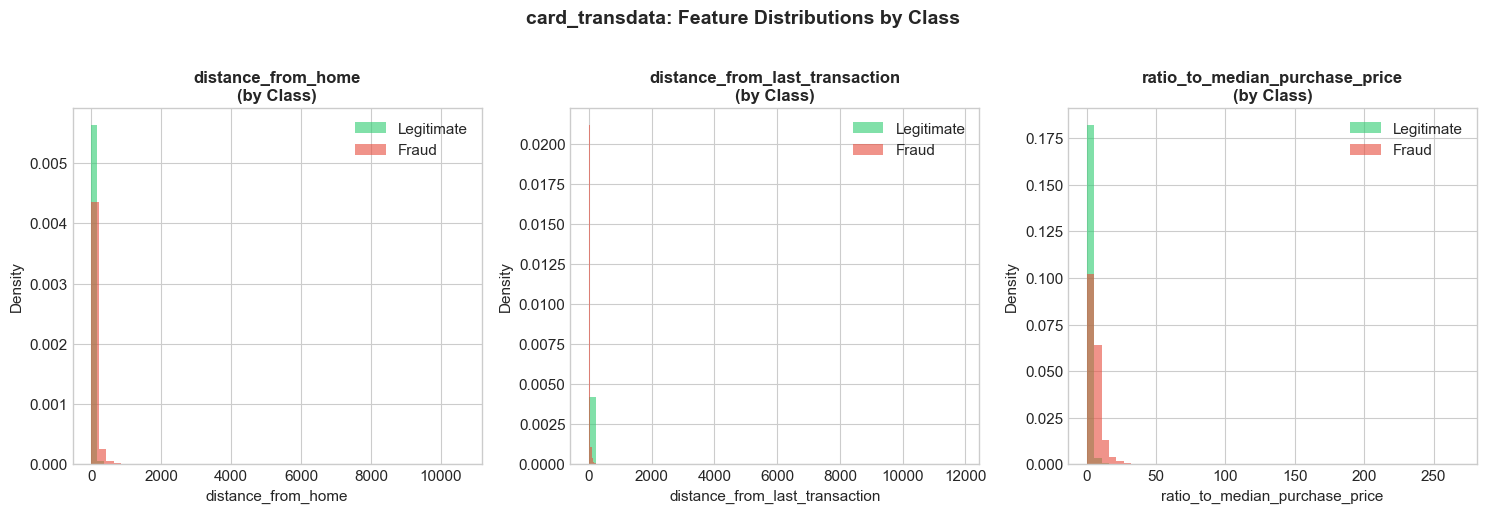

✓ Saved to: ..\results\card_transdata\figures\statistical\histograms_by_class.png


In [8]:
# ============================================================
# VISUALIZATIONS: card_transdata - Histograms by Class
# ============================================================

print("Generating histograms for card_transdata...")

# Select continuous features for histograms
hist_features_card = continuous_features_card

fig, axes = plt.subplots(1, len(hist_features_card), figsize=(5*len(hist_features_card), 5))
if len(hist_features_card) == 1:
    axes = [axes]

for i, feature in enumerate(hist_features_card):
    ax = axes[i]
    
    # Separate by class
    legit_data = card_transdata[card_transdata[target_col_card] == 0][feature]
    fraud_data = card_transdata[card_transdata[target_col_card] == 1][feature]
    
    # Plot histograms
    ax.hist(legit_data, bins=50, alpha=0.6, label='Legitimate', color='#2ecc71', density=True)
    ax.hist(fraud_data, bins=50, alpha=0.6, label='Fraud', color='#e74c3c', density=True)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{feature}\n(by Class)', fontsize=12, fontweight='bold')
    ax.legend()

plt.suptitle('card_transdata: Feature Distributions by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

hist_path_card = output_dirs['card_transdata']['figures'] / 'histograms_by_class.png'
plt.savefig(hist_path_card, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to: {hist_path_card}")

Generating boxplots for card_transdata...


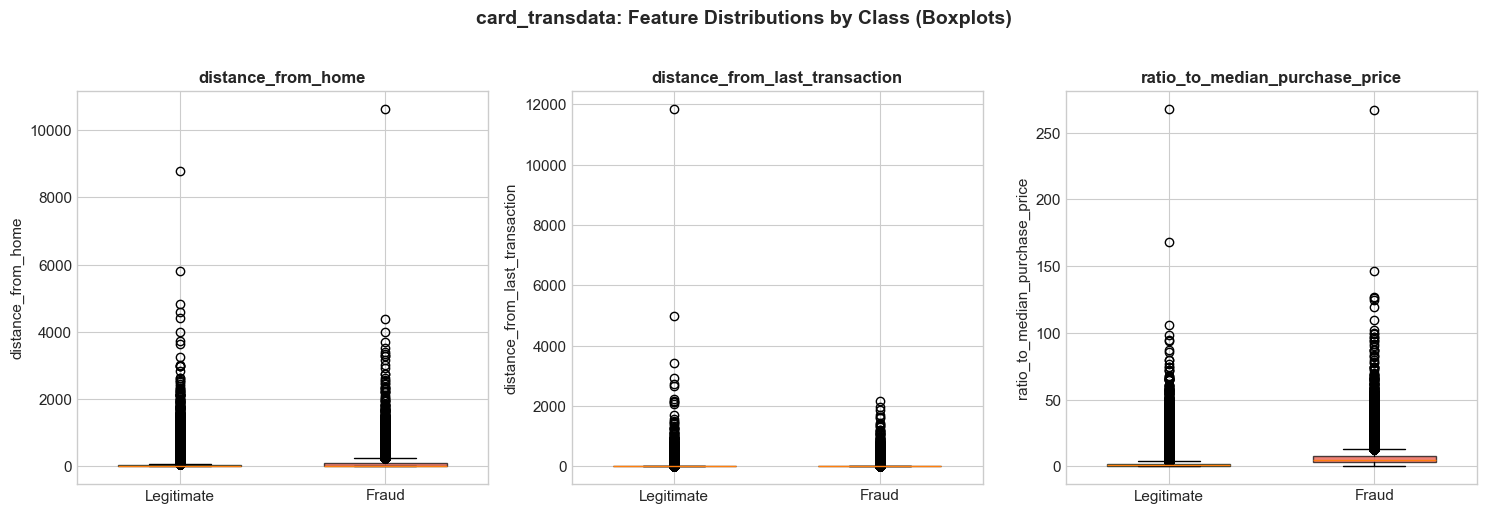

✓ Saved to: ..\results\card_transdata\figures\statistical\boxplots_by_class.png


In [9]:
# ============================================================
# VISUALIZATIONS: card_transdata - Boxplots by Class
# ============================================================

print("Generating boxplots for card_transdata...")

fig, axes = plt.subplots(1, len(hist_features_card), figsize=(5*len(hist_features_card), 5))
if len(hist_features_card) == 1:
    axes = [axes]

for i, feature in enumerate(hist_features_card):
    ax = axes[i]
    
    # Create boxplot data
    legit_data = card_transdata[card_transdata[target_col_card] == 0][feature]
    fraud_data = card_transdata[card_transdata[target_col_card] == 1][feature]
    
    bp = ax.boxplot([legit_data, fraud_data], labels=['Legitimate', 'Fraud'], 
                    patch_artist=True, widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    for box in bp['boxes']:
        box.set_alpha(0.7)
    
    ax.set_ylabel(feature, fontsize=11)
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.suptitle('card_transdata: Feature Distributions by Class (Boxplots)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

box_path_card = output_dirs['card_transdata']['figures'] / 'boxplots_by_class.png'
plt.savefig(box_path_card, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to: {box_path_card}")

Generating histograms for creditcard...


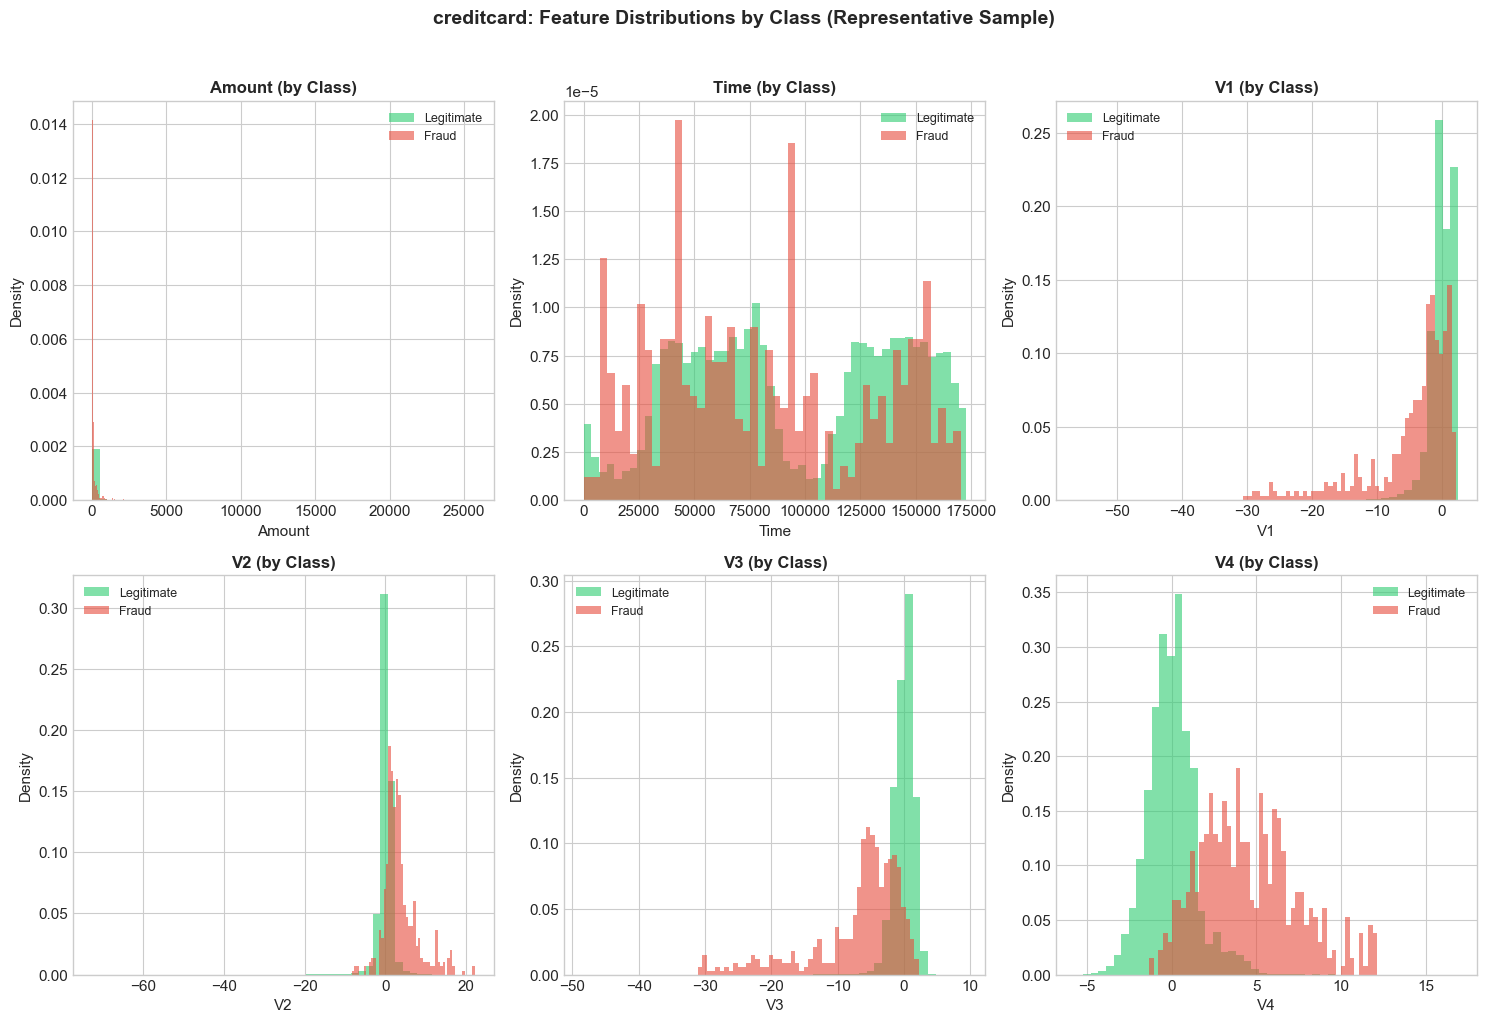

✓ Saved to: ..\results\creditcard\figures\statistical\histograms_by_class.png


In [10]:
# ============================================================
# VISUALIZATIONS: creditcard - Histograms by Class
# ============================================================

print("Generating histograms for creditcard...")

# Select representative features (Amount, Time, and a few V features)
hist_features_cc = ['Amount', 'Time', 'V1', 'V2', 'V3', 'V4']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(hist_features_cc):
    ax = axes[i]
    
    # Separate by class
    legit_data = creditcard[creditcard[target_col_cc] == 0][feature]
    fraud_data = creditcard[creditcard[target_col_cc] == 1][feature]
    
    # Plot histograms
    ax.hist(legit_data, bins=50, alpha=0.6, label='Legitimate', color='#2ecc71', density=True)
    ax.hist(fraud_data, bins=50, alpha=0.6, label='Fraud', color='#e74c3c', density=True)
    
    ax.set_xlabel(feature, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'{feature} (by Class)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)

plt.suptitle('creditcard: Feature Distributions by Class (Representative Sample)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

hist_path_cc = output_dirs['creditcard']['figures'] / 'histograms_by_class.png'
plt.savefig(hist_path_cc, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to: {hist_path_cc}")

Generating boxplots for creditcard...


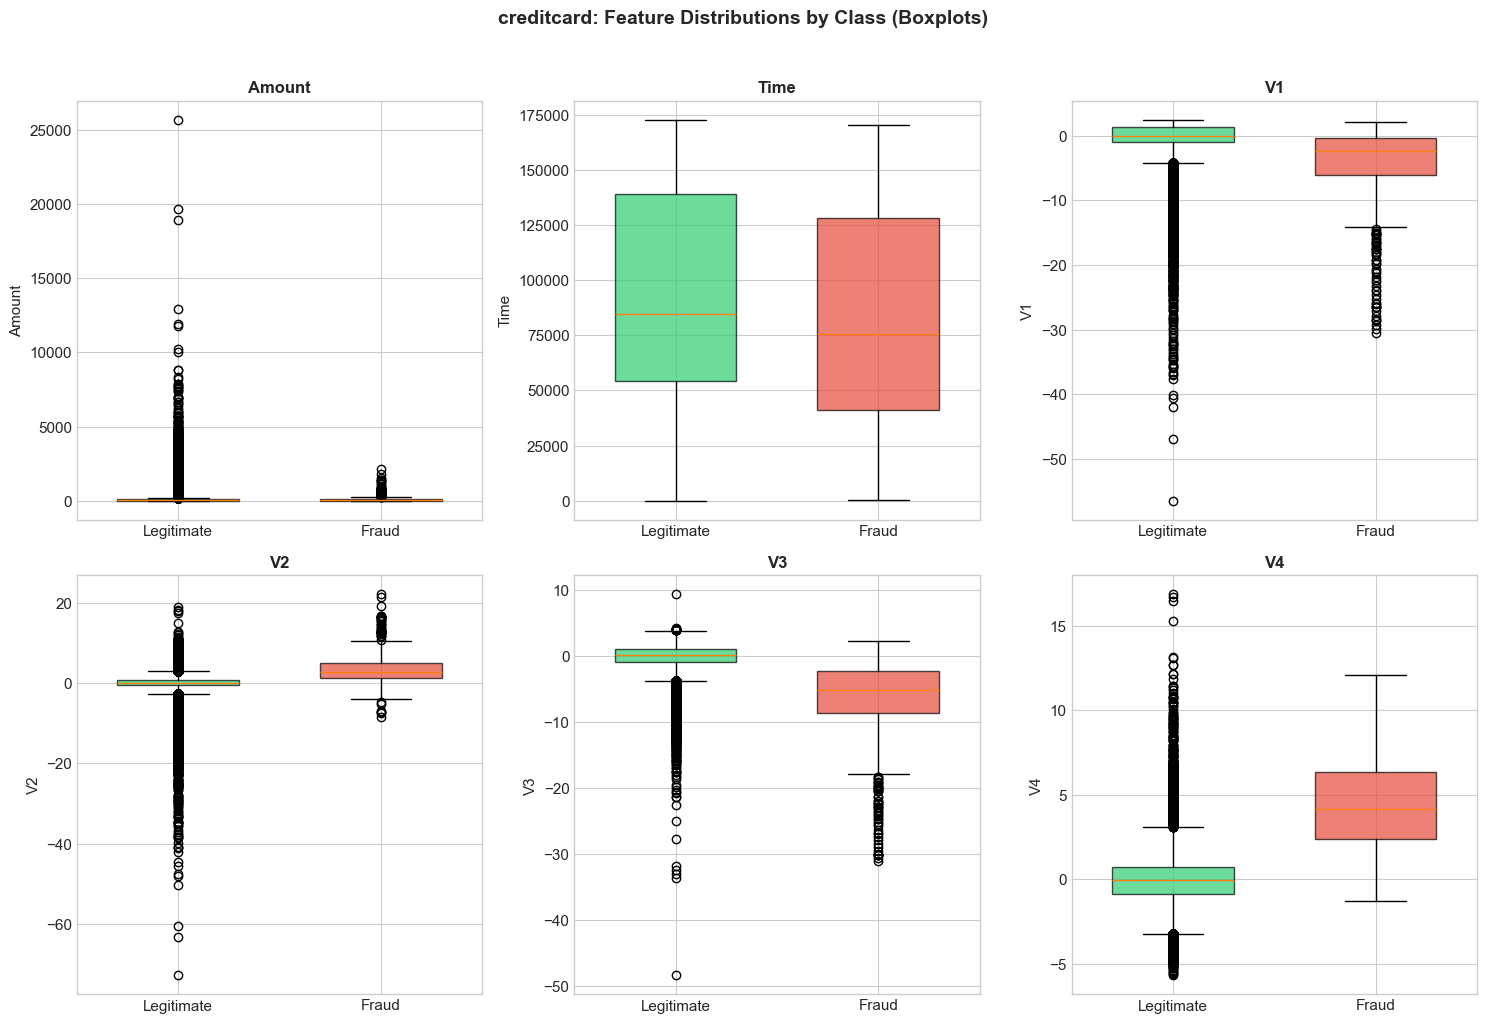

✓ Saved to: ..\results\creditcard\figures\statistical\boxplots_by_class.png


In [11]:
# ============================================================
# VISUALIZATIONS: creditcard - Boxplots by Class
# ============================================================

print("Generating boxplots for creditcard...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(hist_features_cc):
    ax = axes[i]
    
    legit_data = creditcard[creditcard[target_col_cc] == 0][feature]
    fraud_data = creditcard[creditcard[target_col_cc] == 1][feature]
    
    bp = ax.boxplot([legit_data, fraud_data], labels=['Legitimate', 'Fraud'], 
                    patch_artist=True, widths=0.6)
    
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')
    for box in bp['boxes']:
        box.set_alpha(0.7)
    
    ax.set_ylabel(feature, fontsize=11)
    ax.set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.suptitle('creditcard: Feature Distributions by Class (Boxplots)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

box_path_cc = output_dirs['creditcard']['figures'] / 'boxplots_by_class.png'
plt.savefig(box_path_cc, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to: {box_path_cc}")

---

## 4. Normality Tests

### Why Test for Normality?

Many classical statistical tests (e.g., t-tests, ANOVA) assume that data are normally distributed. Before selecting appropriate statistical tests for comparing fraud vs. non-fraud transactions, we must verify whether this assumption holds.

### Method: Shapiro–Wilk Test

The Shapiro–Wilk test is widely used for normality testing:
- **Null hypothesis (H₀):** Data are normally distributed
- **Alternative hypothesis (H₁):** Data are not normally distributed
- **Decision rule:** If p-value < 0.05, reject H₀ (data are not normal)

### Sampling Note

Due to computational constraints (Shapiro–Wilk is limited to n ≤ 5000), we use random samples of 5000 observations per feature.

### Expectation

Financial transaction data typically exhibit:
- Heavy right-skewed distributions (e.g., transaction amounts)
- Multimodal patterns
- Non-normal behavior

This justifies the use of **non-parametric tests** in subsequent analyses.

In [12]:
# ============================================================
# NORMALITY TESTS: card_transdata
# ============================================================

print("=" * 70)
print("NORMALITY TESTS: card_transdata.csv")
print("=" * 70)

# Test continuous features
normality_results_card = []
sample_size = 5000  # Shapiro-Wilk limit

for feature in continuous_features_card:
    # Sample data
    data = card_transdata[feature].dropna()
    if len(data) > sample_size:
        data = data.sample(n=sample_size, random_state=RANDOM_SEED)
    
    # Perform Shapiro-Wilk test
    stat, p_value = stats.shapiro(data)
    
    # Determine normality
    is_normal = 'Yes' if p_value >= 0.05 else 'No'
    
    normality_results_card.append({
        'Feature': feature,
        'Shapiro-Wilk Statistic': round(stat, 6),
        'p-value': f'{p_value:.2e}' if p_value < 0.001 else round(p_value, 6),
        'Normal (α=0.05)': is_normal
    })

normality_df_card = pd.DataFrame(normality_results_card)

print("\n📊 Shapiro–Wilk Normality Test Results:")
print(f"   (Sample size: {sample_size} per feature)")
print()
print(normality_df_card.to_string(index=False))

# Count results
n_normal = (normality_df_card['Normal (α=0.05)'] == 'Yes').sum()
n_not_normal = (normality_df_card['Normal (α=0.05)'] == 'No').sum()

print(f"\n📊 Summary:")
print(f"   • Normal features: {n_normal}")
print(f"   • Non-normal features: {n_not_normal}")

# Save results
normality_path_card = output_dirs['card_transdata']['tables'] / 'normality_tests.csv'
normality_df_card.to_csv(normality_path_card, index=False)
print(f"\n✓ Saved to: {normality_path_card}")

NORMALITY TESTS: card_transdata.csv

📊 Shapiro–Wilk Normality Test Results:
   (Sample size: 5000 per feature)

                       Feature  Shapiro-Wilk Statistic  p-value Normal (α=0.05)
            distance_from_home                0.355762 1.00e-85              No
distance_from_last_transaction                0.151877 5.44e-92              No
ratio_to_median_purchase_price                0.533597 1.19e-78              No

📊 Summary:
   • Normal features: 0
   • Non-normal features: 3

✓ Saved to: ..\results\card_transdata\tables\statistical\normality_tests.csv


In [13]:
# ============================================================
# NORMALITY TESTS: creditcard
# ============================================================

print("=" * 70)
print("NORMALITY TESTS: creditcard.csv")
print("=" * 70)

# Test representative features (Amount, Time, and selected V features)
test_features_cc = ['Amount', 'Time', 'V1', 'V2', 'V3', 'V4', 'V14', 'V17']

normality_results_cc = []

for feature in test_features_cc:
    data = creditcard[feature].dropna()
    if len(data) > sample_size:
        data = data.sample(n=sample_size, random_state=RANDOM_SEED)
    
    stat, p_value = stats.shapiro(data)
    is_normal = 'Yes' if p_value >= 0.05 else 'No'
    
    normality_results_cc.append({
        'Feature': feature,
        'Shapiro-Wilk Statistic': round(stat, 6),
        'p-value': f'{p_value:.2e}' if p_value < 0.001 else round(p_value, 6),
        'Normal (α=0.05)': is_normal
    })

normality_df_cc = pd.DataFrame(normality_results_cc)

print("\n📊 Shapiro–Wilk Normality Test Results:")
print(f"   (Sample size: {sample_size} per feature)")
print()
print(normality_df_cc.to_string(index=False))

n_normal_cc = (normality_df_cc['Normal (α=0.05)'] == 'Yes').sum()
n_not_normal_cc = (normality_df_cc['Normal (α=0.05)'] == 'No').sum()

print(f"\n📊 Summary:")
print(f"   • Normal features: {n_normal_cc}")
print(f"   • Non-normal features: {n_not_normal_cc}")

# Save results
normality_path_cc = output_dirs['creditcard']['tables'] / 'normality_tests.csv'
normality_df_cc.to_csv(normality_path_cc, index=False)
print(f"\n✓ Saved to: {normality_path_cc}")

NORMALITY TESTS: creditcard.csv

📊 Shapiro–Wilk Normality Test Results:
   (Sample size: 5000 per feature)

Feature  Shapiro-Wilk Statistic  p-value Normal (α=0.05)
 Amount                0.364058 1.95e-85              No
   Time                0.939956 5.15e-41              No
     V1                0.812107 2.05e-60              No
     V2                0.685109 1.80e-70              No
     V3                0.936787 8.33e-42              No
     V4                0.969412 2.30e-31              No
    V14                0.938202 1.86e-41              No
    V17                0.854977 1.14e-55              No

📊 Summary:
   • Normal features: 0
   • Non-normal features: 8

✓ Saved to: ..\results\creditcard\tables\statistical\normality_tests.csv


### Interpretation of Normality Results

As expected, the vast majority of features in both datasets are **not normally distributed** (p < 0.05). This is typical for financial transaction data, which often exhibits:

1. **Right-skewed distributions** — Most transactions are small; a few are very large
2. **Heavy tails** — Extreme values are more common than a normal distribution would predict
3. **Multimodality** — Distinct transaction patterns (e.g., online vs. in-person)

**Consequence**: Since the normality assumption is violated, we must use **non-parametric statistical tests** for comparing fraud vs. non-fraud groups:
- **Mann–Whitney U test** (instead of independent t-test) for continuous features
- **Chi-square test** for binary/categorical features

---

## 5. Statistical Tests Between Groups

This section tests whether features differ significantly between fraud and non-fraud transactions.

### Tests Used

| Feature Type | Test | Effect Size |
|--------------|------|-------------|
| Continuous | Mann–Whitney U | Cohen's d |
| Binary/Categorical | Chi-square (χ²) | Cramér's V |

### Why Effect Size Matters

With large sample sizes (hundreds of thousands of observations), even trivial differences become "statistically significant" (p < 0.05). **Effect size** measures the *magnitude* of the difference, not just its statistical detectability:

| Cohen's d | Interpretation |
|-----------|----------------|
| 0.2 | Small effect |
| 0.5 | Medium effect |
| 0.8+ | Large effect |

| Cramér's V | Interpretation |
|------------|----------------|
| 0.1 | Small effect |
| 0.3 | Medium effect |
| 0.5+ | Large effect |

In [14]:
# ============================================================
# HELPER FUNCTIONS FOR STATISTICAL TESTS
# ============================================================

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size for two groups."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return 0.0
    
    return (group1.mean() - group2.mean()) / pooled_std


def cramers_v(contingency_table):
    """Calculate Cramér's V effect size from a contingency table."""
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    
    if min_dim == 0 or n == 0:
        return 0.0
    
    return np.sqrt(chi2 / (n * min_dim))


def interpret_cohens_d(d):
    """Interpret Cohen's d effect size."""
    d = abs(d)
    if d < 0.2:
        return 'Negligible'
    elif d < 0.5:
        return 'Small'
    elif d < 0.8:
        return 'Medium'
    else:
        return 'Large'


def interpret_cramers_v(v):
    """Interpret Cramér's V effect size."""
    if v < 0.1:
        return 'Negligible'
    elif v < 0.3:
        return 'Small'
    elif v < 0.5:
        return 'Medium'
    else:
        return 'Large'


print("✓ Helper functions defined")

✓ Helper functions defined


In [15]:
# ============================================================
# STATISTICAL TESTS: card_transdata
# ============================================================

print("=" * 70)
print("STATISTICAL TESTS: card_transdata.csv")
print("=" * 70)

# Separate groups
legit_card = card_transdata[card_transdata[target_col_card] == 0]
fraud_card = card_transdata[card_transdata[target_col_card] == 1]

test_results_card = []

# A. Continuous Features - Mann-Whitney U Test
print("\n📊 A. Continuous Features (Mann–Whitney U Test):")
print("-" * 60)

for feature in continuous_features_card:
    legit_vals = legit_card[feature].dropna()
    fraud_vals = fraud_card[feature].dropna()
    
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(legit_vals, fraud_vals, alternative='two-sided')
    
    # Effect size (Cohen's d)
    d = cohens_d(fraud_vals, legit_vals)
    
    test_results_card.append({
        'Feature': feature,
        'Type': 'Continuous',
        'Test': 'Mann-Whitney U',
        'Statistic': round(stat, 2),
        'p-value': f'{p_value:.2e}' if p_value < 0.001 else round(p_value, 6),
        'Significant (α=0.05)': 'Yes' if p_value < 0.05 else 'No',
        'Effect Size': round(abs(d), 4),
        'Effect Size Type': "Cohen's d",
        'Interpretation': interpret_cohens_d(d)
    })

# B. Binary Features - Chi-square Test
print("\n📊 B. Binary Features (Chi-square Test):")
print("-" * 60)

for feature in binary_features_card:
    # Create contingency table
    contingency = pd.crosstab(card_transdata[feature], card_transdata[target_col_card])
    
    # Chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    # Effect size (Cramér's V)
    v = cramers_v(contingency)
    
    test_results_card.append({
        'Feature': feature,
        'Type': 'Binary',
        'Test': 'Chi-square',
        'Statistic': round(chi2, 2),
        'p-value': f'{p_value:.2e}' if p_value < 0.001 else round(p_value, 6),
        'Significant (α=0.05)': 'Yes' if p_value < 0.05 else 'No',
        'Effect Size': round(v, 4),
        'Effect Size Type': "Cramér's V",
        'Interpretation': interpret_cramers_v(v)
    })

# Create DataFrame and display
test_df_card = pd.DataFrame(test_results_card)
print("\n📊 Complete Results:")
print(test_df_card.to_string(index=False))

# Save results
test_path_card = output_dirs['card_transdata']['tables'] / 'statistical_tests_results.csv'
test_df_card.to_csv(test_path_card, index=False)
print(f"\n✓ Saved to: {test_path_card}")

STATISTICAL TESTS: card_transdata.csv

📊 A. Continuous Features (Mann–Whitney U Test):
------------------------------------------------------------

📊 B. Binary Features (Chi-square Test):
------------------------------------------------------------

📊 Complete Results:
                       Feature       Type           Test    Statistic   p-value Significant (α=0.05)  Effect Size Effect Size Type Interpretation
            distance_from_home Continuous Mann-Whitney U 3.213396e+10  0.00e+00                  Yes       0.6761        Cohen's d         Medium
distance_from_last_transaction Continuous Mann-Whitney U 3.705598e+10 3.05e-263                  Yes       0.3268        Cohen's d          Small
ratio_to_median_purchase_price Continuous Mann-Whitney U 1.193061e+10  0.00e+00                  Yes       1.8460        Cohen's d          Large
               repeat_retailer     Binary     Chi-square 1.830000e+00  0.176384                   No       0.0014       Cramér's V     Negligible

In [16]:
# ============================================================
# STATISTICAL TESTS: creditcard
# ============================================================

print("=" * 70)
print("STATISTICAL TESTS: creditcard.csv")
print("=" * 70)

# Separate groups
legit_cc = creditcard[creditcard[target_col_cc] == 0]
fraud_cc = creditcard[creditcard[target_col_cc] == 1]

# Select representative features for testing
test_continuous_cc = ['Amount', 'Time', 'V1', 'V2', 'V3', 'V4', 'V14', 'V17']

test_results_cc = []

print("\n📊 Continuous Features (Mann–Whitney U Test):")
print("-" * 60)

for feature in test_continuous_cc:
    legit_vals = legit_cc[feature].dropna()
    fraud_vals = fraud_cc[feature].dropna()
    
    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(legit_vals, fraud_vals, alternative='two-sided')
    
    # Effect size (Cohen's d)
    d = cohens_d(fraud_vals, legit_vals)
    
    test_results_cc.append({
        'Feature': feature,
        'Type': 'Continuous',
        'Test': 'Mann-Whitney U',
        'Statistic': round(stat, 2),
        'p-value': f'{p_value:.2e}' if p_value < 0.001 else round(p_value, 6),
        'Significant (α=0.05)': 'Yes' if p_value < 0.05 else 'No',
        'Effect Size': round(abs(d), 4),
        'Effect Size Type': "Cohen's d",
        'Interpretation': interpret_cohens_d(d)
    })

# Create DataFrame and display
test_df_cc = pd.DataFrame(test_results_cc)
print("\n📊 Complete Results:")
print(test_df_cc.to_string(index=False))

# Save results
test_path_cc = output_dirs['creditcard']['tables'] / 'statistical_tests_results.csv'
test_df_cc.to_csv(test_path_cc, index=False)
print(f"\n✓ Saved to: {test_path_cc}")

STATISTICAL TESTS: creditcard.csv

📊 Continuous Features (Mann–Whitney U Test):
------------------------------------------------------------

📊 Complete Results:
Feature       Type           Test   Statistic   p-value Significant (α=0.05)  Effect Size Effect Size Type Interpretation
 Amount Continuous Mann-Whitney U  78049581.0  8.58e-06                  Yes       0.1356        Cohen's d     Negligible
   Time Continuous Mann-Whitney U  81310602.0  4.39e-10                  Yes       0.2968        Cohen's d          Small
     V1 Continuous Mann-Whitney U 111193870.0 1.74e-113                  Yes       2.4531        Cohen's d          Large
     V2 Continuous Mann-Whitney U  20289296.0 1.65e-163                  Yes       2.2075        Cohen's d          Large
     V3 Continuous Mann-Whitney U 127583455.0 1.21e-219                  Yes       4.7356        Cohen's d          Large
     V4 Continuous Mann-Whitney U   8636598.0 3.63e-248                  Yes       3.2425        Cohen's d

Generating effect size comparison plots...


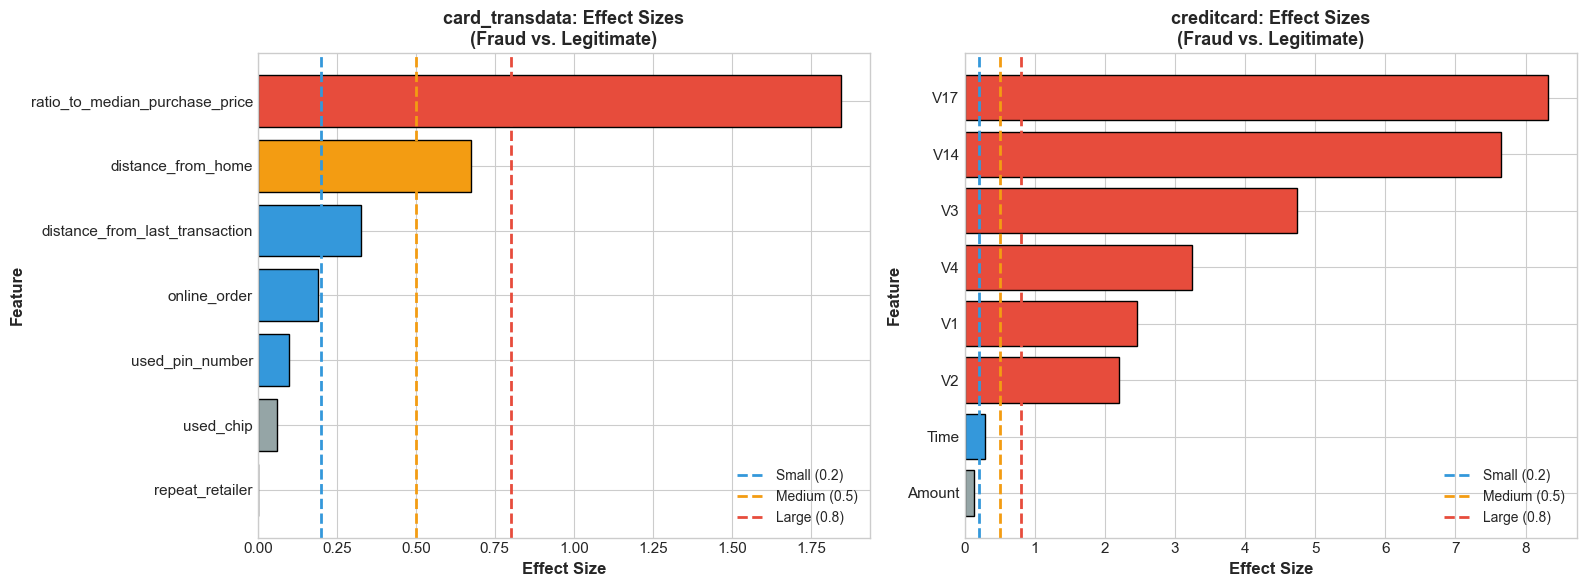

✓ Saved to: ..\results\card_transdata\figures\statistical\effect_sizes_comparison.png
✓ Saved to: ..\results\creditcard\figures\statistical\effect_sizes_comparison.png


In [17]:
# ============================================================
# VISUALIZATION: Effect Size Comparison
# ============================================================

print("Generating effect size comparison plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: card_transdata
test_df_card_sorted = test_df_card.sort_values('Effect Size', ascending=True)
colors_card = ['#e74c3c' if x == 'Large' else '#f39c12' if x == 'Medium' 
               else '#3498db' if x == 'Small' else '#95a5a6' 
               for x in test_df_card_sorted['Interpretation']]

ax1.barh(test_df_card_sorted['Feature'], test_df_card_sorted['Effect Size'], 
         color=colors_card, edgecolor='black', linewidth=1)
ax1.axvline(x=0.2, color='#3498db', linestyle='--', linewidth=2, label='Small (0.2)')
ax1.axvline(x=0.5, color='#f39c12', linestyle='--', linewidth=2, label='Medium (0.5)')
ax1.axvline(x=0.8, color='#e74c3c', linestyle='--', linewidth=2, label='Large (0.8)')
ax1.set_xlabel('Effect Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax1.set_title('card_transdata: Effect Sizes\n(Fraud vs. Legitimate)', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)

# Right: creditcard
test_df_cc_sorted = test_df_cc.sort_values('Effect Size', ascending=True)
colors_cc = ['#e74c3c' if x == 'Large' else '#f39c12' if x == 'Medium' 
             else '#3498db' if x == 'Small' else '#95a5a6' 
             for x in test_df_cc_sorted['Interpretation']]

ax2.barh(test_df_cc_sorted['Feature'], test_df_cc_sorted['Effect Size'], 
         color=colors_cc, edgecolor='black', linewidth=1)
ax2.axvline(x=0.2, color='#3498db', linestyle='--', linewidth=2, label='Small (0.2)')
ax2.axvline(x=0.5, color='#f39c12', linestyle='--', linewidth=2, label='Medium (0.5)')
ax2.axvline(x=0.8, color='#e74c3c', linestyle='--', linewidth=2, label='Large (0.8)')
ax2.set_xlabel('Effect Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax2.set_title('creditcard: Effect Sizes\n(Fraud vs. Legitimate)', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)

plt.tight_layout()

# Save to both directories
effect_path_card = output_dirs['card_transdata']['figures'] / 'effect_sizes_comparison.png'
effect_path_cc = output_dirs['creditcard']['figures'] / 'effect_sizes_comparison.png'
plt.savefig(effect_path_card, dpi=150, bbox_inches='tight')
plt.savefig(effect_path_cc, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved to: {effect_path_card}")
print(f"✓ Saved to: {effect_path_cc}")

---

## 6. Interpretation of Results

### 6.1 Statistical Significance vs. Practical Importance

A critical observation from this analysis is the distinction between **statistical significance** and **practical importance**:

- With sample sizes of ~284,000 (creditcard) and ~1,000,000 (card_transdata), even tiny differences become statistically significant (p < 0.001).
- However, **effect sizes** reveal the *magnitude* of these differences, which matters more for practical applications.

### 6.2 Key Findings: card_transdata (Synthetic)

**Continuous Features:**
- All three continuous features show significant differences between fraud and legitimate transactions.
- Effect sizes vary considerably, with some features showing **large** effects (suggesting strong discriminative power).

**Binary Features:**
- Binary features (e.g., `used_chip`, `used_pin_number`, `online_order`) show significant associations with fraud.
- Cramér's V values indicate the strength of these associations.

### 6.3 Key Findings: creditcard (Real-World)

**PCA-Transformed Features:**
- Some V-features (particularly V14, V17) show medium to large effect sizes, indicating they capture meaningful fraud-related variance.
- The PCA transformation was performed by the original data providers for confidentiality reasons.

**Amount and Time:**
- Transaction amount shows modest differences between fraud and legitimate transactions.
- Time-of-day patterns may differ between fraud and legitimate transactions.

### 6.4 Why These Tests Are NOT Used for Feature Selection

**Important clarification**: These statistical tests are exploratory and descriptive. They are **not** used for:

1. **Automated feature selection** — Neural networks learn complex non-linear relationships that univariate tests cannot capture.
2. **Replacing ML modeling** — These tests assume linear/monotonic relationships; fraud detection involves complex interactions.
3. **Model training decisions** — All features are retained; the NN determines their importance through learned weights.

### 6.5 How This Analysis Supports the ML Pipeline

This statistical analysis provides:

1. **Understanding of data characteristics** — Class imbalance, distribution shapes, feature variability.
2. **Justification for methodological choices** — Why PR-AUC over accuracy, why non-parametric tests, why threshold optimization.
3. **Academic rigor** — Demonstrates understanding of statistical foundations underlying ML.
4. **Interpretability context** — Helps explain which features might drive model decisions.

---

## 7. Summary for Written Report

### How This Section Is Used in the Final Report

This notebook fulfills the course requirement for **"statistical analysis for tabular data: descriptive statistics, normality tests, statistical tests between features, effect sizes."**

### Tables to Include in Written Report

| Table | Location | Purpose |
|-------|----------|----------|
| `statistical_data_description.csv` | Both datasets | Dataset overview |
| `descriptive_statistics.csv` | Both datasets | Central tendency & dispersion |
| `normality_tests.csv` | Both datasets | Justifies non-parametric tests |
| `statistical_tests_results.csv` | Both datasets | Group comparison with effect sizes |

### Figures to Reference in Written Report

| Figure | Location | Purpose |
|--------|----------|----------|
| `histograms_by_class.png` | Both datasets | Distribution visualization |
| `boxplots_by_class.png` | Both datasets | Central tendency comparison |
| `effect_sizes_comparison.png` | Both datasets | Practical significance |

### Key Points for Written Report

1. **Class Imbalance**: The creditcard dataset has extreme imbalance (0.17% fraud vs. 8.7% in synthetic data), justifying the use of PR-AUC over accuracy.

2. **Non-Normality**: Features are not normally distributed, justifying the use of non-parametric tests (Mann–Whitney U, Chi-square).

3. **Effect Sizes**: Statistical significance alone is misleading with large samples; effect sizes provide meaningful interpretation.

4. **Exploratory Purpose**: This analysis supports understanding and documentation, not feature selection or model training.

### Checklist for Report Completeness

- [x] Descriptive statistics computed and saved
- [x] Normality tests performed (Shapiro–Wilk)
- [x] Statistical tests between groups (Mann–Whitney U, Chi-square)
- [x] Effect sizes calculated (Cohen's d, Cramér's V)
- [x] Interpretation of results provided
- [x] All tables and figures saved

In [18]:
# ============================================================
# FINAL SUMMARY: ALL SAVED ARTIFACTS
# ============================================================

print("=" * 70)
print(" NOTEBOOK 09 COMPLETE: STATISTICAL ANALYSIS FOR REPORT")
print("=" * 70)

print("\n📁 SAVED TABLES:")
print("\n  card_transdata:")
for f in output_dirs['card_transdata']['tables'].glob('*.csv'):
    print(f"    ✓ {f.name}")

print("\n  creditcard:")
for f in output_dirs['creditcard']['tables'].glob('*.csv'):
    print(f"    ✓ {f.name}")

print("\n📊 SAVED FIGURES:")
print("\n  card_transdata:")
for f in output_dirs['card_transdata']['figures'].glob('*.png'):
    print(f"    ✓ {f.name}")

print("\n  creditcard:")
for f in output_dirs['creditcard']['figures'].glob('*.png'):
    print(f"    ✓ {f.name}")

print("\n" + "=" * 70)
print(" ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 70)
print("\n✅ This notebook fulfills the statistical analysis requirement.")
print("\n📝 For the written report:")
print("   1. Reference tables from results/{dataset}/tables/statistical/")
print("   2. Include figures from results/{dataset}/figures/statistical/")
print("   3. Use the interpretation in Section 6 as a template")
print("\n⚠️  Reminder: This analysis is for documentation only.")
print("    It does NOT replace or modify the ML modeling pipeline.")

 NOTEBOOK 09 COMPLETE: STATISTICAL ANALYSIS FOR REPORT

📁 SAVED TABLES:

  card_transdata:
    ✓ descriptive_statistics.csv
    ✓ normality_tests.csv
    ✓ statistical_data_description.csv
    ✓ statistical_tests_results.csv

  creditcard:
    ✓ descriptive_statistics.csv
    ✓ normality_tests.csv
    ✓ statistical_data_description.csv
    ✓ statistical_tests_results.csv

📊 SAVED FIGURES:

  card_transdata:
    ✓ boxplots_by_class.png
    ✓ effect_sizes_comparison.png
    ✓ histograms_by_class.png

  creditcard:
    ✓ boxplots_by_class.png
    ✓ effect_sizes_comparison.png
    ✓ histograms_by_class.png

 ANALYSIS COMPLETED SUCCESSFULLY

✅ This notebook fulfills the statistical analysis requirement.

📝 For the written report:
   1. Reference tables from results/{dataset}/tables/statistical/
   2. Include figures from results/{dataset}/figures/statistical/
   3. Use the interpretation in Section 6 as a template

⚠️  Reminder: This analysis is for documentation only.
    It does NOT repla